# Import Libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy
import networkx as nx
import matplotlib.pyplot as plt

# load the data
DATA_DIR = os.path.join("data")

gene_data = pd.read_csv(os.path.join(DATA_DIR, "rdata.csv"))
social_data = pd.read_csv(os.path.join(DATA_DIR, "sdata.csv"))

with open(os.path.join(DATA_DIR, "mice_sex.json"), "r+") as f:
    sex_data = json.load(f)

mice_social_data = pd.read_csv(os.path.join(DATA_DIR, "mice_contact_sequence.csv"))

id2sex = dict()
for sex, id_list in sex_data.items():
    for n in id_list:
        id2sex[n] = sex

## Create Networks

In [ ]:
gene_network = nx.Graph()
gene_nodes = set(gene_data["from"]) | set(gene_data["to"])
for node in gene_nodes:
    gene_network.add_node(node)

for _, row in gene_data.iterrows():
    gene_network.add_edge(row["from"], row["to"], weight=row["weight"])

social_network = nx.Graph()
social_nodes = set(social_data["from"]) | set(social_data["to"])
for node in social_nodes:
    social_network.add_node(node)

for _, row in social_data.iterrows():
    social_network.add_edge(row["from"], row["to"], weight=row["weight"])

mice_social_network = nx.Graph()
mice_social_nodes = set(mice_social_data["source_nodes"]) | set(mice_social_data["target_nodes"])
for node in mice_social_nodes:
    sex = id2sex.get(int(node), "unknown")
    mice_social_network.add_node(node, sex=sex)

for _, row in mice_social_data.iterrows():
    source = row["source_nodes"]
    target = row["target_nodes"]
    if mice_social_network.has_edge(source, target):
        mice_social_network[source][target]["weight"] += row["durations"]
    else:
        mice_social_network.add_edge(row["source_nodes"], row["target_nodes"], weight=row["durations"])

In [ ]:
author_mice_social_network = nx.Graph()
mice_social_nodes = set(mice_social_data["source_nodes"]) | set(mice_social_data["target_nodes"])
for node in mice_social_nodes:
    sex = id2sex.get(int(node), "unknown")
    author_mice_social_network.add_node(node, sex=sex)

mice_social_total = {x: 0 for x in mice_social_nodes}
for _, row in mice_social_data.iterrows():
    mice_social_total[row["source_nodes"]] += row["durations"]
    mice_social_total[row["target_nodes"]] += row["durations"]

for _, row in mice_social_data.iterrows():
    source = row["source_nodes"]
    target = row["target_nodes"]
    if author_mice_social_network.has_edge(source, target):
        author_mice_social_network[source][target]["weight"] += row["durations"] / (mice_social_total[source] + mice_social_total[target])
    else:
        author_mice_social_network.add_edge(row["source_nodes"], row["target_nodes"], weight=row["durations"] / (mice_social_total[source] + mice_social_total[target]))

## Basic Visualization

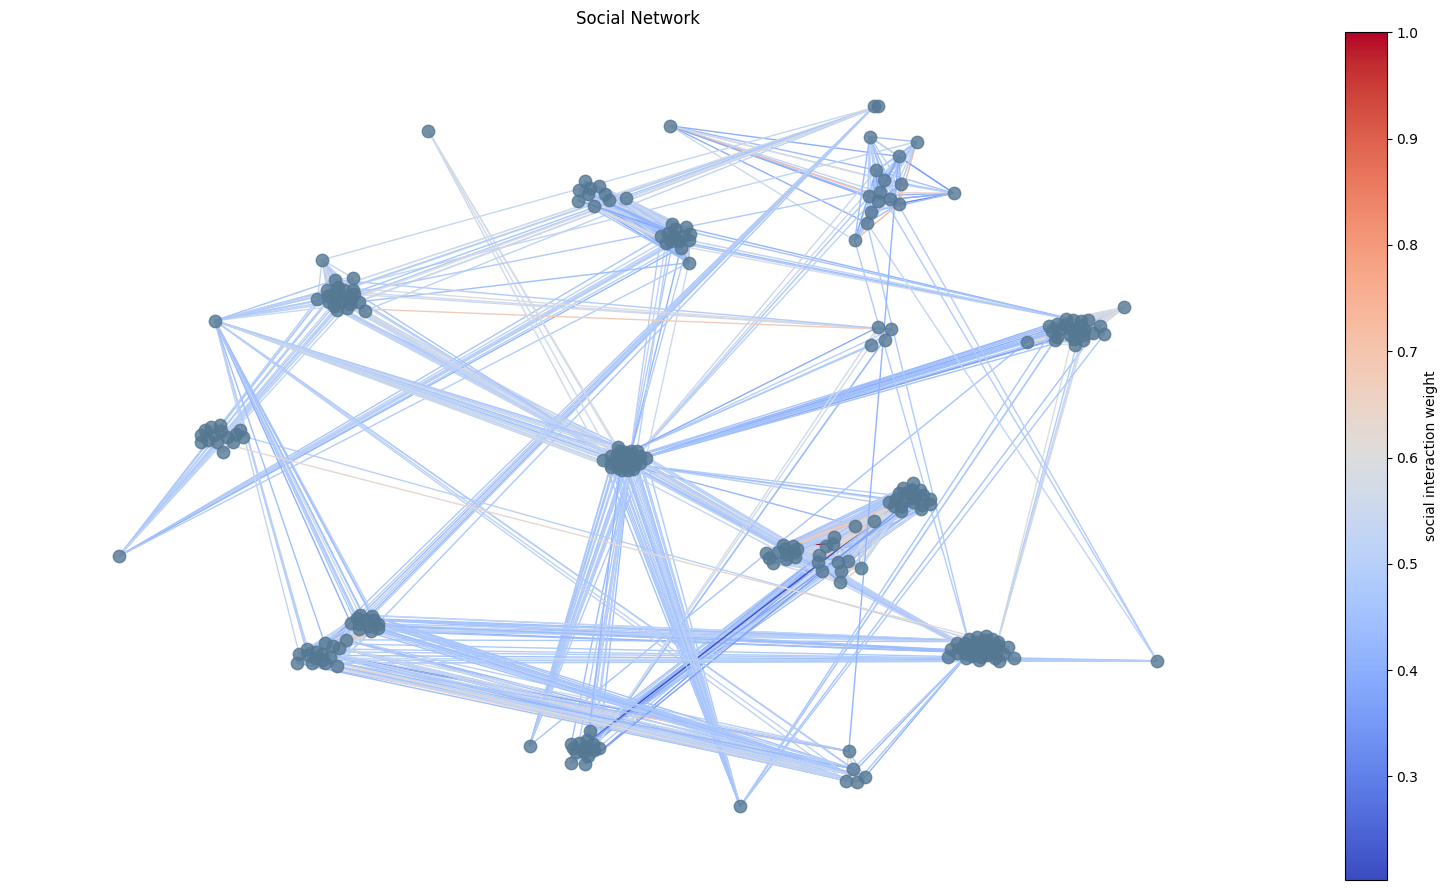

In [ ]:
# set the figure size
fig, ax = plt.subplots(figsize=(16, 9))

# calculate the layout of the points
pos = nx.spring_layout(social_network, seed=42)

# get the weights
social_edges = social_network.edges()
gene_weights = [gene_network[u][v]['weight'] for u, v in social_edges]

# plot the points
nx.draw_networkx_nodes(
    social_network, 
    pos, 
    ax=ax, 
    node_size=80, 
    node_color="#547792", 
    alpha=0.8
)

edges = nx.draw_networkx_edges(
    social_network,
    pos,
    ax=ax, 
    width=1,
    edge_color=gene_weights, 
    edge_cmap=plt.cm.coolwarm, 
    edge_vmin=min(gene_weights),
    edge_vmax=max(gene_weights)
)

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(gene_weights), vmax=max(gene_weights)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='social interaction weight')

plt.title("Social Network")
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
gene_data

,from,to,weight
0,00074FF772,0007287D33,0.523481
1,00074FF772,00074FF81A,0.460213
2,00074FF772,00074FAAE8,0.423226
3,00074FF772,00071A5DC5,0.456910
4,00074FF772,000728CA76,0.444758
...,...,...,...
35773,00074C2204,00074C3620,0.375992
35774,00074C2204,00072900AE,0.469430
35775,000728BF7D,00074C3620,0.500961
35776,000728BF7D,00072900AE,0.468640


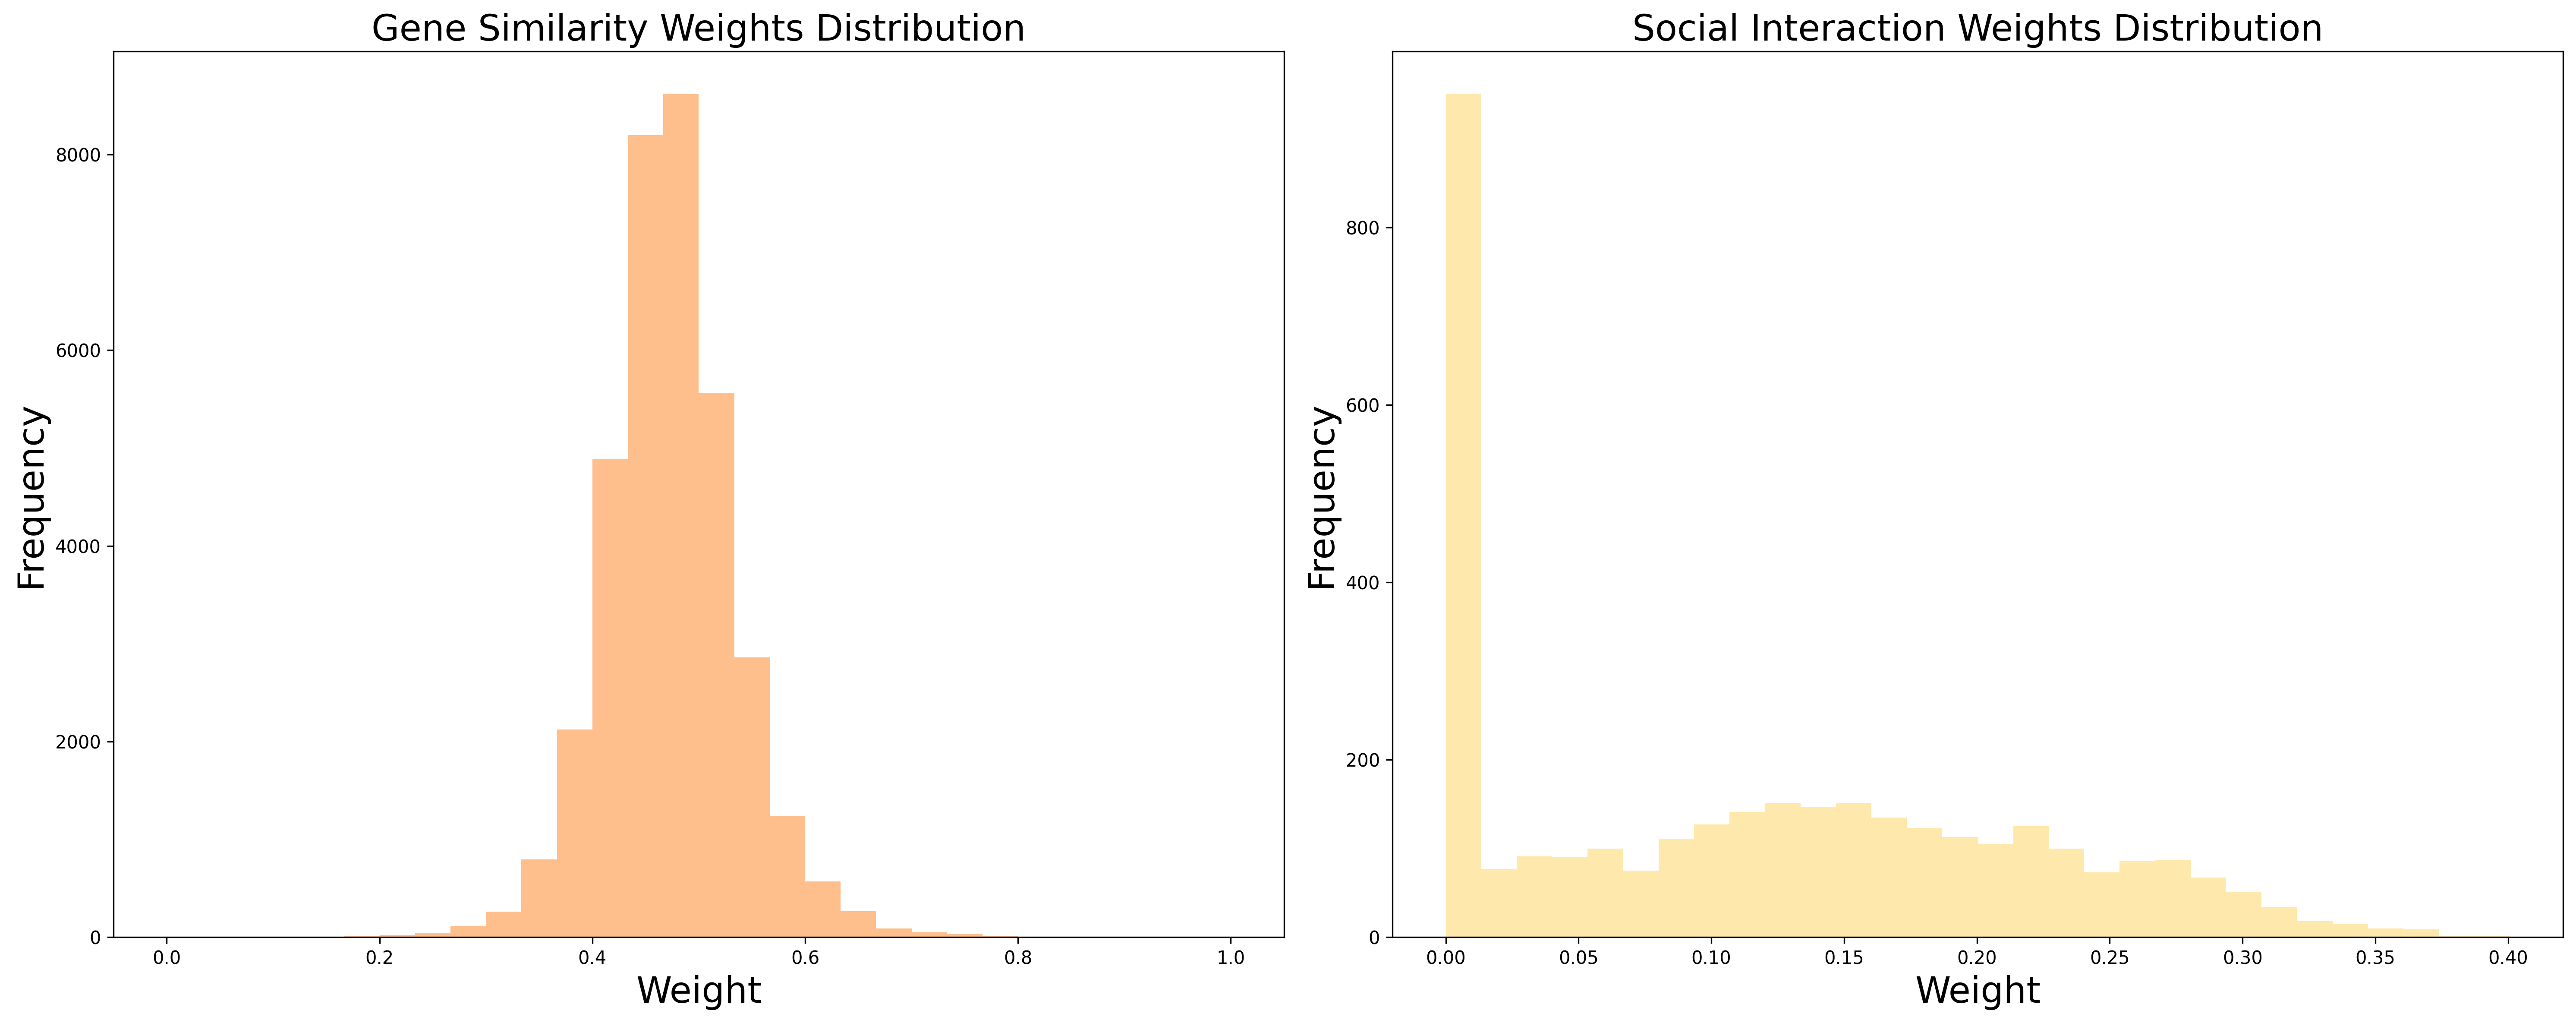

In [ ]:
# distribution
gene_weights = [gene_network[u][v]['weight'] for u, v in gene_network.edges()]
social_weights = [social_network[u][v]['weight'] for u, v in social_network.edges()]

fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
axes[0].hist(gene_weights, bins=30, color='#FFA55D', alpha=0.7)
axes[0].set_title("Gene Similarity Weights Distribution", fontsize=20)
axes[0].set_xlabel("Weight", fontsize=20)
axes[0].set_ylabel("Frequency", fontsize=20)

axes[1].hist(social_weights, bins=30, color='#FFDF88', alpha=0.7)
axes[1].set_title("Social Interaction Weights Distribution", fontsize=20)
axes[1].set_xlabel("Weight", fontsize=20)
axes[1].set_ylabel("Frequency", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
nx.density(G)

0.09658220141498541

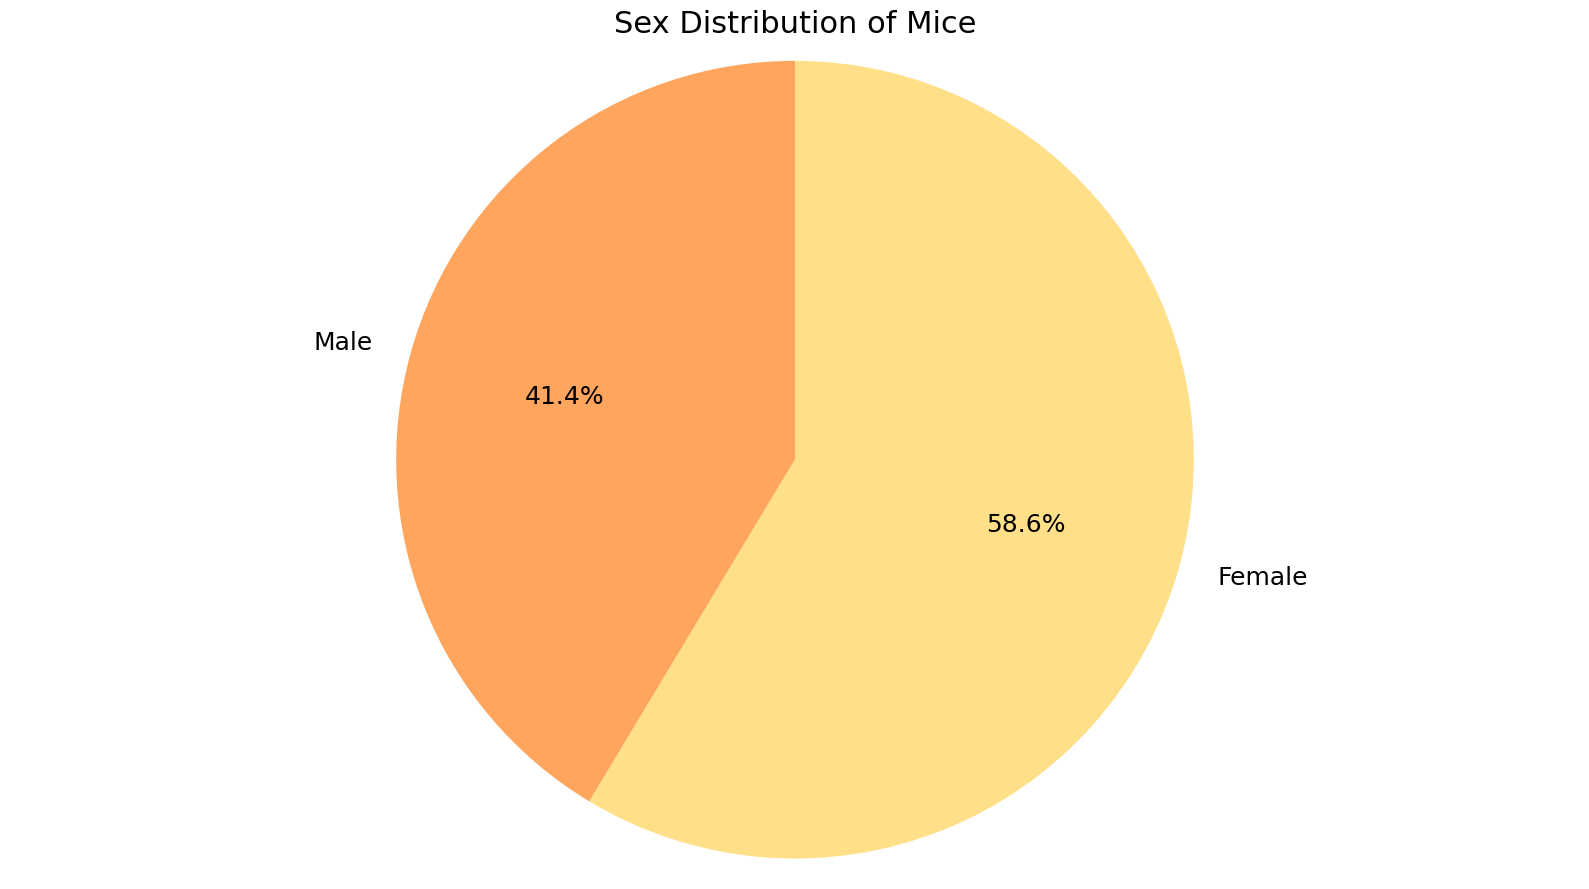

In [ ]:
# sex distribution
male_mice = [m for m, s in id2sex.items() if s == "male"]
female_mice = [m for m, s in id2sex.items() if s == "female"]

fig, ax = plt.subplots(figsize=(16, 9))
ax.pie(
    [len(male_mice), len(female_mice)], 
    labels=["Male", "Female"], 
    autopct='%1.1f%%', 
    colors=["#FFA55D", "#FFDF88"],
    textprops={'fontsize': 18},
    startangle=90
)
ax.set_title("Sex Distribution of Mice", fontsize=22)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

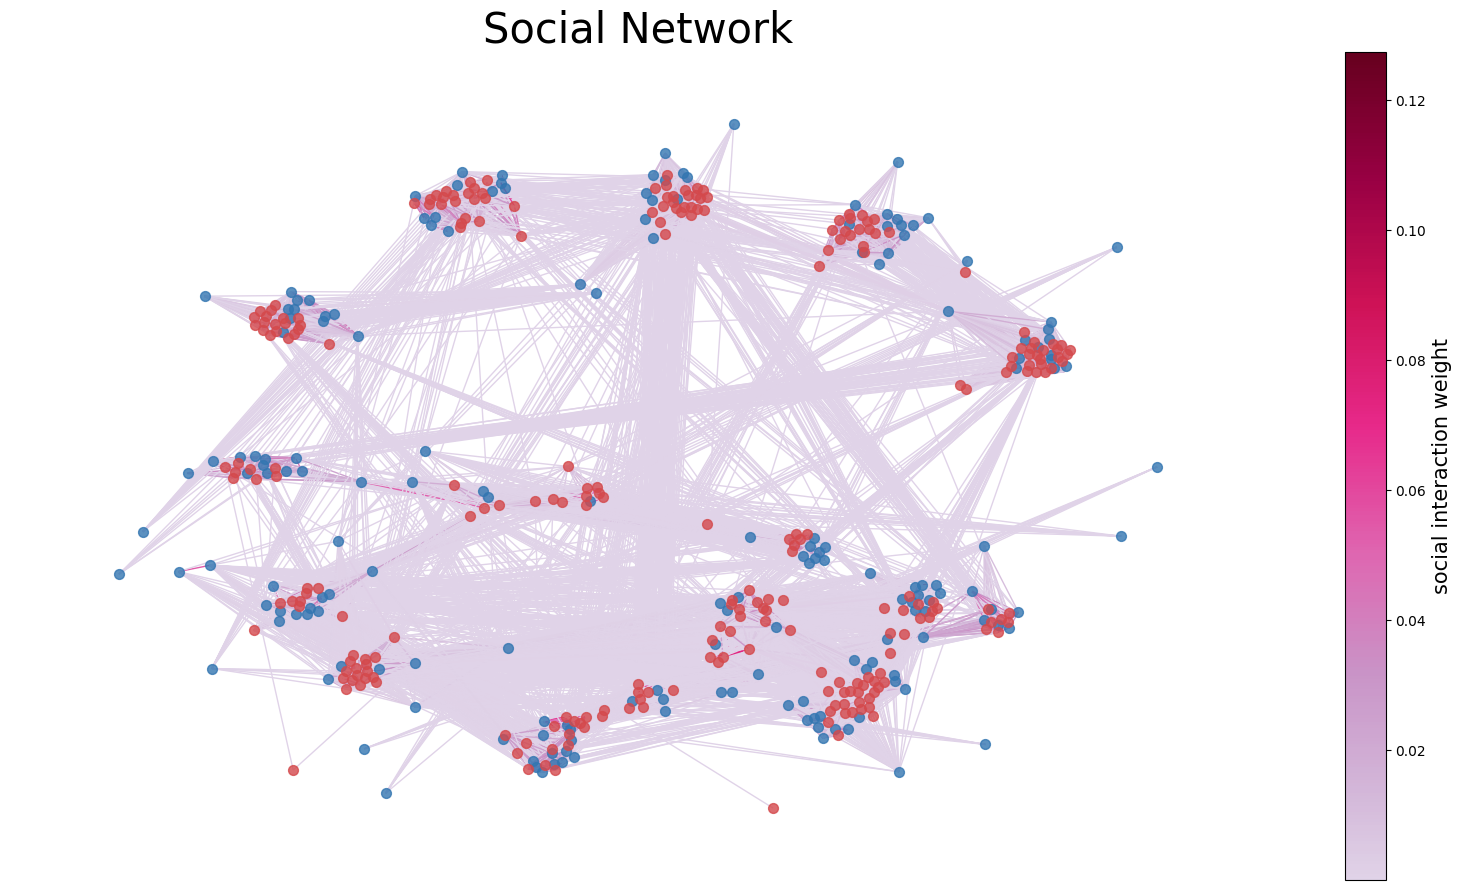

In [ ]:
# set the size of the ax
import matplotlib
fig, ax = plt.subplots(figsize=(16, 9))

# record the position of nodes
pos = nx.spring_layout(author_mice_social_network, seed=42)
male_mice = [m[0] for m in author_mice_social_network.nodes(data=True)]
female_mice = [m[0] for m in author_mice_social_network.nodes(data=True)]

# social_edges = mice_social_network.edges()
# social_weights = np.array([mice_social_network[u][v]['weight'] for u, v in social_edges])
# social_weights = np.clip(social_weights, a_min=0, a_max=10000)
# social_weights = np.log(social_weights + 1)

social_edges = author_mice_social_network.edges()
social_weights = np.array([author_mice_social_network[u][v]['weight'] for u, v in social_edges])

nx.draw_networkx_nodes(
    author_mice_social_network, 
    pos, 
    ax=ax, 
    nodelist=[m for m, att in author_mice_social_network.nodes(data=True) if att["sex"]=="male"], 
    node_size=50,
    node_color="#3376B1", 
    alpha=0.8
)

nx.draw_networkx_nodes(
    author_mice_social_network, 
    pos, 
    ax=ax, 
    nodelist=[m for m, att in author_mice_social_network.nodes(data=True) if att["sex"]=="female"], 
    node_size=50,
    node_color="#D4494C", 
    alpha=0.8
)

cmap = plt.cm.PuRd
cmap = cmap(np.linspace(0.17, 1, 256))
cmap = matplotlib.colors.ListedColormap(cmap)

edges = nx.draw_networkx_edges(
    author_mice_social_network,
    pos,
    ax=ax, 
    width=1,
    edge_color=social_weights, 
    edge_cmap=cmap, 
    edge_vmin=min(social_weights),
    edge_vmax=max(social_weights)
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(social_weights), vmax=max(social_weights)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='social interaction weight')
cbar.set_label("social interaction weight", fontsize=15)

plt.title("Social Network", fontsize=30)
plt.axis('off')
plt.tight_layout()
plt.show()

# Analysis

In [ ]:
# the correlation between gene similarity and social interaction
from scipy.stats import pearsonr
nodes = list(set(social_network.nodes()) | set(gene_network.nodes()))
gene_weights_list = []
social_weights_list = []

for u_x, u in enumerate(nodes[:-1]):
    for v_x, v in enumerate(nodes[u_x + 1:]):
        if not social_network.has_edge(u, v):
            social_weights_list.append(0)
        else:
            social_network_weight = social_network[u][v]["weight"]
            social_weights_list.append(social_network_weight)
        gene_network_weight = gene_network[u][v]["weight"]
        gene_weights_list.append(gene_network_weight)

# calculate pearson
correlation, p_val = pearsonr(gene_weights_list, social_weights_list)
print(f"Correlation Coefficient: {correlation}")
print(f"P-value: {p_val:.4f}")

Correlation Coefficient: 0.23102222776470638
P-value: 0.0000


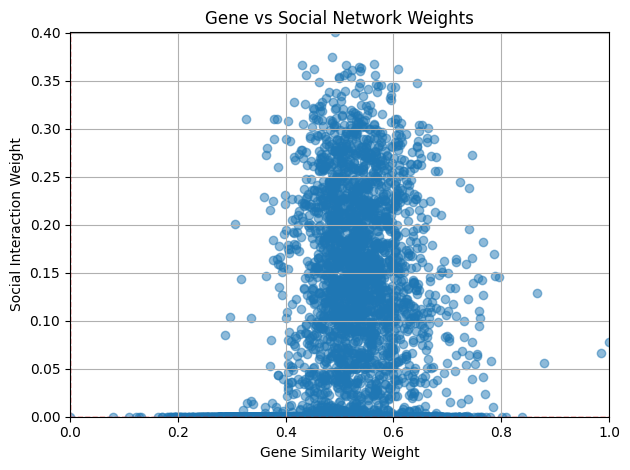

In [59]:
plt.scatter(gene_weights_list, social_weights_list, alpha=0.5)
plt.xlabel("Gene Similarity Weight")
plt.ylabel("Social Interaction Weight")
plt.title("Gene vs Social Network Weights")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlim(min(gene_weights_list), max(gene_weights_list))
plt.ylim(min(social_weights_list), max(social_weights_list))
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr
# calculate the correlation between gene and sex
small_mice_data = mice_social_data[["source_nodes", "target_nodes", "durations"]].copy()
small_mice_data["sex1"] = small_mice_data["source_nodes"].map(lambda x: id2sex.get(int(x), "unknown"))
small_mice_data["sex2"] = small_mice_data["target_nodes"].map(lambda x: id2sex.get(int(x), "unknown"))
small_mice_data = small_mice_data.loc[(small_mice_data["sex1"] != "unknown") & (small_mice_data["sex2"] != "unknown")]
small_mice_data["sex_similarity"] = small_mice_data["sex1"] == small_mice_data["sex2"]


In [43]:
durations = np.log(np.clip(small_mice_data["durations"], 0, 10000) + 1)
durations = (durations - np.mean(durations)) / np.std(durations)

sex_correlation, p_val = pearsonr(small_mice_data["sex_similarity"], durations)
sex_correlation

np.float64(-0.00264347462997575)

# animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation

mice_social_data.sort_values(by="starting_times", inplace=True)
mices = list(set(mice_social_data["source_nodes"]) | set(mice_social_data["target_nodes"]))

G = nx.Graph()
pos = {}

pos = nx.spring_layout(author_mice_social_network, seed=42)

G = nx.Graph()

fig, ax = plt.subplots(figsize=(16, 9))

frames = len(mice_social_data) // 10000 + 1

ax.axis('off')

def update(frame):
    ax.clear()
    
    # add nodes and edges for the current frame
    for m, row in mice_social_data.iloc[frame * 10000:(frame + 1) * 10000].iterrows():
        source = row["source_nodes"]
        target = row["target_nodes"]
        if source not in G:
            source_sex = id2sex.get(int(source), "unknown")
            G.add_node(source, sex=source_sex)
        if target not in G:
            target_sex = id2sex.get(int(target), "unknown")
            G.add_node(target, sex=target_sex)
        if G.has_edge(source, target):
            G[source][target]["weight"] += row["durations"] / (mice_social_total[source] + mice_social_total[target])
        else:
            G.add_edge(source, target, weight=row["durations"] / (mice_social_total[source] + mice_social_total[target]))
    
    male_mice = [m for m, att in G.nodes(data=True) if att["sex"]=="male"]
    female_mice = [m for m, att in G.nodes(data=True) if att["sex"]=="female"]

    social_edges = G.edges()
    social_weights = np.array([G[u][v]['weight'] for u, v in social_edges])
    social_weights = np.clip(social_weights, a_min=0, a_max=10000)
    social_weights = np.log(social_weights + 1)

    nx.draw_networkx_nodes(
        G, 
        pos, 
        ax=ax, 
        nodelist=male_mice, 
        node_size=50,
        node_color="#3376B1", 
        alpha=0.8
    )

    nx.draw_networkx_nodes(
        G, 
        pos, 
        ax=ax, 
        nodelist=female_mice, 
        node_size=50,
        node_color="#D4494C", 
        alpha=0.8
    )

    edges = nx.draw_networkx_edges(
        G,
        pos,
        ax=ax, 
        width=1,         
        edge_color=social_weights, 
        edge_cmap=cmap,
        edge_vmin=min(social_weights),
        edge_vmax=max(social_weights),
        alpha=0.5
    )

    # if frame == 0:
    #     sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(social_weights), vmax=max(social_weights)))
    #     sm.set_array([])
    #     cbar = plt.colorbar(sm, ax=ax, label='social interaction weight')
    ax.axis('off')
    ax.set_title(f"Step {frame}")

ani = FuncAnimation(fig, update, frames=frames, interval=50, repeat=True)
ani.save("network_evolution.gif", writer="pillow")
plt.close()

# Clusters

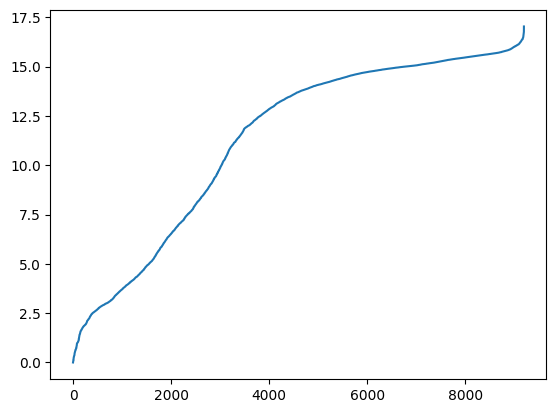

In [29]:
special_social_weights = np.log(social_weights)
special_social_weights -= np.min(special_social_weights)
plt.plot(np.sort(special_social_weights))

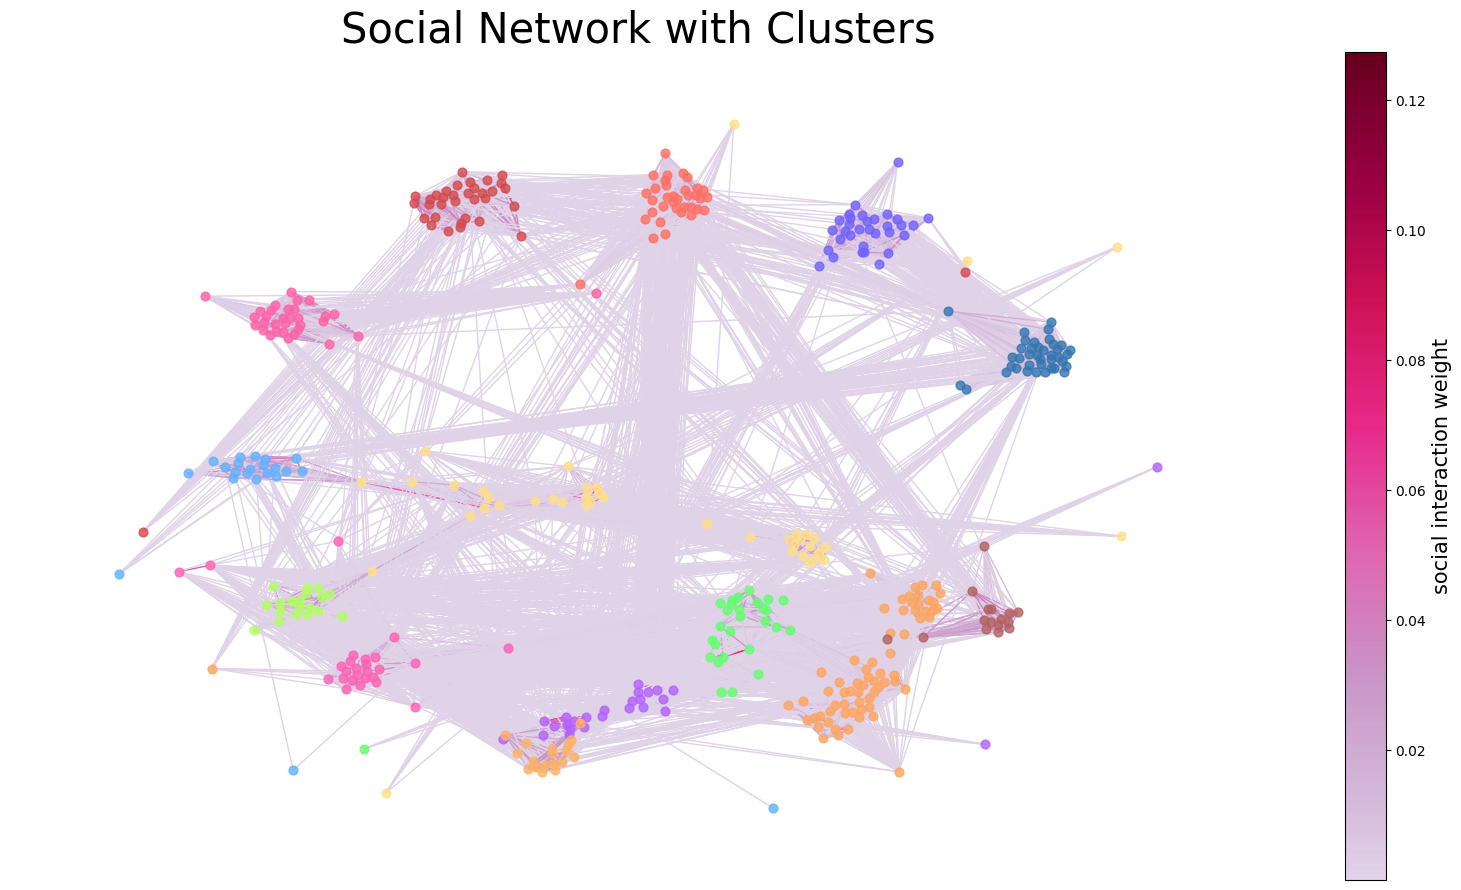

In [ ]:
clusters = nx.algorithms.community.greedy_modularity_communities(author_mice_social_network, weight="weight")
clusters = list(clusters)
cluster_colors = ["#FFA55D", "#FFDF88", "#3376B1", "#D4494C", "#FF6F61", "#6F61FF", "#FF61A6", "#61FF6F", "#FF61B2", "#B261FF", "#61B2FF", "#B2FF61", "#FFB261", "#B26161", "#61B261", "#B2B261", "#B261B2", "#61B2B2", "#B2B2FF"]

fig, ax = plt.subplots(figsize=(16, 9))

pos = nx.spring_layout(author_mice_social_network, seed=42)

for n, cluster in enumerate(clusters):
    nx.draw_networkx_nodes(
        author_mice_social_network, 
        pos, 
        ax=ax, 
        nodelist=cluster, 
        node_size=40,
        node_color=cluster_colors[n], 
        alpha=0.8
    )

edges = nx.draw_networkx_edges(
        author_mice_social_network,
        pos,
        ax=ax, 
        width=1,
        edge_color=social_weights,
        edge_cmap=cmap,
        edge_vmin=min(social_weights),
        edge_vmax=max(social_weights),
    )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(social_weights), vmax=max(social_weights)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("social interaction weight", fontsize=15)

plt.title("Social Network with Clusters", fontsize=30)
plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
modularity = nx.algorithms.community.modularity(author_mice_social_network, clusters)
modularity

np.float64(0.9035847651424079)

In [12]:
inner_edges = []
outer_edges = []

for u, v in mice_social_network.edges():
    for cluster in clusters:
        if u in cluster and v in cluster:
            inner_edges.append((u, v))
            break

In [ ]:
# calculate the number of edges int the cluster for each node
mice_edges = {x: [0, 0] for x in mice_social_network.nodes()}
for u, v in mice_social_network.edges():
    u_cluster = None
    v_cluster = None
    for cluster in clusters:
        if u in cluster:
            u_cluster = cluster
        if v in cluster:
            v_cluster = cluster
    if u_cluster == v_cluster:
        mice_edges[u][0] += 1
        mice_edges[v][0] += 1
    else:
        mice_edges[u][1] += 1
        mice_edges[v][1] += 1

proportions = []
for node in mice_social_network.nodes():
    proportion = mice_edges[node][0] / (mice_edges[node][0] + mice_edges[node][1])
    proportions.append(proportion)

print(np.average(proportions))


0.7587212938987439
